## Hybrid method: Recursive feature elimination

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score

## Read Data

In [2]:
data = pd.read_csv('../Kyoto_Train.csv')
data.shape

(124055, 24)

In [4]:
data.head()

,Duration,Source,Destination_bytes,Count,Same_srv_rate,Serror_rate,Srv_serror_rate,Dst_host_count,Dst_host_srv_count,Dst_host_same_port_rate,...,Service_code,Flag_code,IDS_detection_code,Malware_detection_code,Ashula_detection_code,Source_IP_Address_code,Destination_IP_Address_code,Start_Time_code,Protocol_code,Label_code
0,2.863309,0,0,0,0.0,0.0,1.00,0,0,0.00,...,6.0,6.0,0.0,0.0,0.0,90847.0,14024.0,25836.0,1.0,0.0
1,0.000000,0,0,0,0.0,0.0,1.00,0,0,0.00,...,6.0,6.0,0.0,0.0,0.0,218531.0,8968.0,45541.0,1.0,0.0
2,0.000000,0,0,0,0.0,0.0,1.00,0,0,0.00,...,6.0,6.0,0.0,0.0,0.0,176665.0,15997.0,59860.0,1.0,0.0
3,0.000000,0,0,0,0.0,0.0,0.67,49,100,0.02,...,6.0,6.0,0.0,0.0,0.0,52769.0,473.0,40649.0,1.0,0.0
4,0.000000,0,0,1,1.0,0.0,0.36,0,2,0.00,...,6.0,0.0,0.0,0.0,0.0,65048.0,16609.0,39283.0,1.0,0.0


### Train - Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Label_code'], axis=1),
    data['Label_code'],
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((99244, 23), (24811, 23))

### Remove constant and quasi-constant features

In [6]:
# to speed things up we remove constant, quasi-constand and duplicated features
quasi_constant_feat = []

# iterate over every feature
for feature in X_train.columns:

    # find the predominant value, that is the value that is shared
    # by most observations
    predominant = (X_train[feature].value_counts() / np.float64(
        len(X_train))).sort_values(ascending=False).values[0]

    # evaluate the predominant feature: do more than 99% of the observations
    # show 1 value?
    if predominant > 0.998:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((99244, 21), (24811, 21))

### Remove duplicated features

In [7]:
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20


0

In [8]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((99244, 21), (24811, 21))

### Build ML model with all features

In [9]:
# build initial model using all the features
model_full = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)
model_full.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_full.predict_proba(X_test)[:, 1]
roc_full = roc_auc_score(y_test, y_pred_test)

print('Test ROC AUC=%f' % (roc_full))

Test ROC AUC=0.999383


### Rank features by importance

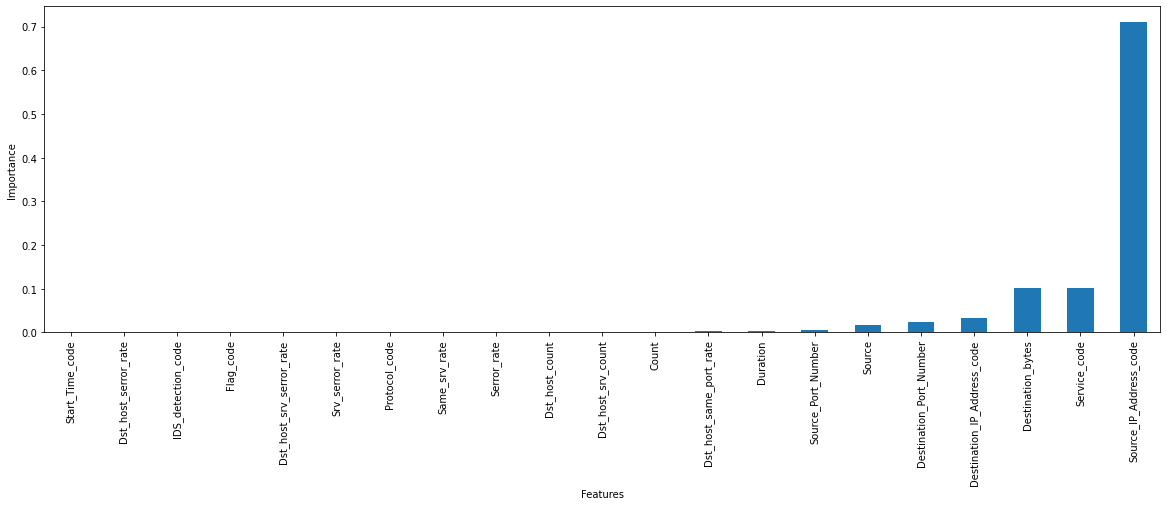

In [10]:
# get feature name and importance
features = pd.Series(model_full.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=True, inplace=True)

# plot
features.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [11]:
# make list of ordered features
features = list(features.index)
features

['Start_Time_code',
 'Dst_host_serror_rate',
 'IDS_detection_code',
 'Flag_code',
 'Dst_host_srv_serror_rate',
 'Srv_serror_rate',
 'Protocol_code',
 'Same_srv_rate',
 'Serror_rate',
 'Dst_host_count',
 'Dst_host_srv_count',
 'Count',
 'Dst_host_same_port_rate',
 'Duration',
 'Source_Port_Number',
 'Source',
 'Destination_Port_Number',
 'Destination_IP_Address_code',
 'Destination_bytes',
 'Service_code',
 'Source_IP_Address_code']

### Select features

In [12]:
# first we arbitrarily set the drop in roc-auc
# if the drop is below this threshold, the feature will be removed
tol = 0.0005

print('doing recursive feature elimination')

# we initialise a list where we will collect the features we should remove
features_to_remove = []

# set a counter to know where the loop is
count = 1

# now we loop over all the features, in order of importance:
# remember that features is this list are ordered by importance
for feature in features:
    
    print()
    print('testing feature: ', feature, count, ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

    # fit model with all variables, minus the feature to be evaluated
    # and also minus all features that were deemed to be removed
    
    # note that features_to_remove will be empty in the first rounds
    # but will have features as the loop proceeds
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # make a prediction using the test set
    y_pred_test = model_int.predict_proba(
        X_test.drop(features_to_remove + [feature], axis=1))[:, 1]

    # calculate the new roc-auc
    roc_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((roc_int)))

    # print the original roc-auc with all the features
    print('Full dataset ROC AUC={}'.format((roc_full)))

    # determine the drop in the roc-auc
    diff_roc = roc_full - roc_int

    # compare the drop in roc-auc with the tolerance
    # we set previously
    if diff_roc >= tol:
        print('Drop in ROC AUC={}'.format(diff_roc))
        print('keep: ', feature)
        print
    else:
        print('Drop in ROC AUC={}'.format(diff_roc))
        print('remove: ', feature)
        print
        # if the drop in the roc is small and we remove the
        # feature, we need to set the new roc to the one based on
        # the remaining features
        roc_full = roc_int
        
        # and append the feature to remove to the collecting list
        features_to_remove.append(feature)

# now the loop is finished, we evaluated all the features
print('Done!')
print('total features to remove: ', len(features_to_remove), )

# determine the features to keep (those we won't remove)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

# Sit back and relax, this will take a while!

doing recursive feature elimination

testing feature:  Start_Time_code 1  out of  21
New Test ROC AUC=0.9993832012295389
Full dataset ROC AUC=0.9993832012295389
Drop in ROC AUC=0.0
remove:  Start_Time_code

testing feature:  Dst_host_serror_rate 2  out of  21
New Test ROC AUC=0.9993832012295389
Full dataset ROC AUC=0.9993832012295389
Drop in ROC AUC=0.0
remove:  Dst_host_serror_rate

testing feature:  IDS_detection_code 3  out of  21
New Test ROC AUC=0.9993832012295389
Full dataset ROC AUC=0.9993832012295389
Drop in ROC AUC=0.0
remove:  IDS_detection_code

testing feature:  Flag_code 4  out of  21
New Test ROC AUC=0.9993832012295389
Full dataset ROC AUC=0.9993832012295389
Drop in ROC AUC=0.0
remove:  Flag_code

testing feature:  Dst_host_srv_serror_rate 5  out of  21
New Test ROC AUC=0.9993832012295389
Full dataset ROC AUC=0.9993832012295389
Drop in ROC AUC=0.0
remove:  Dst_host_srv_serror_rate

testing feature:  Srv_serror_rate 6  out of  21
New Test ROC AUC=0.9993832012295389
Full da

In [13]:
features_to_remove

['Start_Time_code',
 'Dst_host_serror_rate',
 'IDS_detection_code',
 'Flag_code',
 'Dst_host_srv_serror_rate',
 'Srv_serror_rate',
 'Protocol_code',
 'Same_srv_rate',
 'Serror_rate',
 'Dst_host_count',
 'Dst_host_srv_count',
 'Dst_host_same_port_rate',
 'Duration',
 'Source_Port_Number',
 'Source']

In [14]:
# for comparison, building a model with the selected features only

model_final = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# fit the model with the selected features
model_final.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = model_final.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
roc_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (roc_final))

Test selected features ROC AUC=0.999009


The Gradient Boosting model built with 6 features shows a similar performance than the one built the full dataset (you need to scroll up to find this value, we calculated a few cells ago).

In [15]:
X_train = X_train[features_to_keep]
X_test = X_test[features_to_keep]

In [16]:
X_train.shape, X_test.shape

((99244, 6), (24811, 6))

## Standardize Data





In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

## Classifiers




In [18]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

## Metrics Evaluation




In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Logistic Regression





In [20]:
%%time
clf_LR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=1).fit(X_train, y_train)

CPU times: user 67.3 ms, sys: 205 ms, total: 272 ms
Wall time: 1.47 s


In [21]:
pred_y_test = clf_LR.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_test))

f1 = f1_score(y_test, pred_y_test)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_test)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.36008222159526015
F1 Score: 0.22449079275142872
FPR: 0.7047517351841964
TPR: 0.9841541755888651


### Naive Bayes





In [22]:
%%time
clf_NB = GaussianNB(var_smoothing=1e-05).fit(X_train, y_train)

CPU times: user 20.2 ms, sys: 4.42 ms, total: 24.6 ms
Wall time: 22.9 ms


In [23]:
pred_y_testNB = clf_NB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testNB))

f1 = f1_score(y_test, pred_y_testNB)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testNB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.9058885171899561
F1 Score: 0.0
FPR: 1.0
TPR: 1.0


### Random Forest




In [24]:
%%time
clf_RF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100).fit(X_train, y_train)

CPU times: user 3.19 s, sys: 49.4 ms, total: 3.24 s
Wall time: 3.24 s


In [25]:
pred_y_testRF = clf_RF.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testRF))

f1 = f1_score(y_test, pred_y_testRF, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testRF)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
FPR: 1.0
TPR: 1.0


### KNN



In [26]:
%%time
clf_KNN = KNeighborsClassifier(algorithm='auto',leaf_size=1,n_neighbors=2,weights='uniform').fit(X_train, y_train)

CPU times: user 4.6 s, sys: 18.6 ms, total: 4.62 s
Wall time: 4.6 s


In [27]:
pred_y_testKNN = clf_KNN.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, pred_y_testKNN))

f1 = f1_score(y_test, pred_y_testKNN)
print('f1:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testKNN)
print('fpr:', fpr[1])
print('tpr:', tpr[1])

accuracy_score: 0.9058885171899561
f1: 0.0
fpr: 1.0
tpr: 1.0


### CatBoost





In [28]:
%%time
clf_CB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04).fit(X_train, y_train)

0:	learn: 0.6558982	total: 63.7ms	remaining: 3.12s
1:	learn: 0.6207751	total: 74ms	remaining: 1.78s
2:	learn: 0.5890181	total: 81.1ms	remaining: 1.27s
3:	learn: 0.5590509	total: 88.8ms	remaining: 1.02s
4:	learn: 0.5311581	total: 95.6ms	remaining: 861ms
5:	learn: 0.5051729	total: 105ms	remaining: 768ms
6:	learn: 0.4808411	total: 111ms	remaining: 683ms
7:	learn: 0.4580309	total: 118ms	remaining: 620ms
8:	learn: 0.4364536	total: 126ms	remaining: 574ms
9:	learn: 0.4161538	total: 133ms	remaining: 530ms
10:	learn: 0.3969466	total: 140ms	remaining: 495ms
11:	learn: 0.3783081	total: 147ms	remaining: 464ms
12:	learn: 0.3611858	total: 153ms	remaining: 436ms
13:	learn: 0.3451155	total: 160ms	remaining: 411ms
14:	learn: 0.3291760	total: 167ms	remaining: 390ms
15:	learn: 0.3151159	total: 174ms	remaining: 369ms
16:	learn: 0.3018089	total: 181ms	remaining: 351ms
17:	learn: 0.2890017	total: 188ms	remaining: 334ms
18:	learn: 0.2773369	total: 194ms	remaining: 317ms
19:	learn: 0.2656833	total: 201ms	rema

In [29]:
pred_y_testCB = clf_CB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testCB))

f1 = f1_score(y_test, pred_y_testCB, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testCB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
FPR: 1.0
TPR: 1.0


## Model Evaluation




In [30]:
import pandas as pd, numpy as np
test_df = pd.read_csv("../Kyoto_Test.csv")
test_df.shape

(62028, 24)

In [31]:
# Create feature matrix X and target vextor y
y_eval = test_df['Label_code']
X_eval = test_df.drop(columns=['Label_code'])

In [32]:
X_eval = X_eval[features_to_keep]

In [33]:
X_eval.shape

(62028, 6)

### Model Evaluation - Logistic Regression




In [34]:
modelLR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=1)
modelLR.fit(X_train, y_train)

LogisticRegression(C=1, n_jobs=-1, random_state=42)

In [35]:
# Predict on the new unseen test data
y_evalpredLR = modelLR.predict(X_eval)
y_predLR = modelLR.predict(X_test)

In [36]:
train_scoreLR = modelLR.score(X_train, y_train)
test_scoreLR = modelLR.score(X_test, y_test)
print("Training accuracy is ", train_scoreLR)
print("Testing accuracy is ", test_scoreLR)

Training accuracy is  0.9054955463302568
Testing accuracy is  0.36008222159526015


In [64]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreLR)
print('F1 Score:',f1_score(y_test, y_predLR, average='weighted', zero_division=1))
print('Precision Score:',precision_score(y_test, y_predLR, average='weighted', zero_division=1))
print('Recall Score:', recall_score(y_test, y_predLR, average='weighted', zero_division=1))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predLR))

Performance measures for test:
--------
Accuracy: 0.36008222159526015
F1 Score: 0.433592508398206
Precision Score: 0.9127890935969957
Recall Score: 0.36008222159526015
Confusion Matrix:
 [[ 6636 15840]
 [   37  2298]]


### Cross validation - Logistic Regression




In [65]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.90350 (+/- 0.00015)
F1 Score: 0.00000 (+/- 0.00000)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision 

Precision: 0.00000 (+/- 0.00000)
Recall: 0.00000 (+/- 0.00000)


### Model Evaluation - Naive Bayes




In [39]:
modelNB = GaussianNB(var_smoothing=1e-05)
modelNB.fit(X_train, y_train)

GaussianNB(var_smoothing=1e-05)

In [40]:
# Predict on the new unseen test data
y_evalpredNB = modelNB.predict(X_eval)
y_predNB = modelNB.predict(X_test)

In [41]:
train_scoreNB = modelNB.score(X_train, y_train)
test_scoreNB = modelNB.score(X_test, y_test)
print("Training accuracy is ", train_scoreNB)
print("Testing accuracy is ", test_scoreNB)

Training accuracy is  0.4486921123695135
Testing accuracy is  0.9058885171899561


In [60]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreNB)
print('F1 Score:',f1_score(y_test, y_predNB, average='weighted', zero_division=0))
print('Precision Score:',precision_score(y_test, y_predNB, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predNB, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predNB))


Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
Precision Score: 0.8206340055766175
Recall Score: 0.9058885171899561
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


### Cross validation - Naive Bayes




In [61]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.85750 (+/- 0.26279)
F1 Score: 0.02394 (+/- 0.14366)
Precision: 0.01387 (+/- 0.08320)
Recall: 0.08763 (+/- 0.52575)


### Model Evaluation - Random Forest





In [44]:
modelRF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100)
modelRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=70, random_state=0)

In [45]:
# Predict on the new unseen test data
y_evalpredRF = modelRF.predict(X_eval)
y_predRF = modelRF.predict(X_test)

In [46]:
train_scoreRF = modelRF.score(X_train, y_train)
test_scoreRF = modelRF.score(X_test, y_test)
print("Training accuracy is ", train_scoreRF)
print("Testing accuracy is ", test_scoreRF)

Training accuracy is  1.0
Testing accuracy is  0.9058885171899561


In [47]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreRF)
print('F1 Score:', f1_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Precision Score:', precision_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predRF))

Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
Precision Score: 0.8206340055766175
Recall Score: 0.9058885171899561
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


### Cross validation - Random Forest





In [48]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.99987 (+/- 0.00028)
F1 Score: 0.99933 (+/- 0.00146)
Precision: 0.99950 (+/- 0.00213)
Recall: 0.99916 (+/- 0.00224)


### Model Evaluation - KNN





In [49]:
modelKNN = KNeighborsClassifier(algorithm='auto',leaf_size=1,n_neighbors=2,weights='uniform')
modelKNN.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=1, n_neighbors=2)

In [50]:
# Predict on the new unseen test data
y_evalpredKNN = modelKNN.predict(X_eval)
y_predKNN = modelKNN.predict(X_test)

In [51]:
train_scoreKNN = modelKNN.score(X_train, y_train)
test_scoreKNN = modelKNN.score(X_test, y_test)
print("Training accuracy is ", train_scoreKNN)
print("Testing accuracy is ", test_scoreKNN)

Training accuracy is  0.9981157551086212
Testing accuracy is  0.9058885171899561


In [52]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreKNN)
print('F1 Score:', f1_score(y_test, y_predKNN))
print('Precision Score:', precision_score(y_test, y_predKNN))
print('Recall Score:', recall_score(y_test, y_predKNN))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predKNN))

Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.0
Precision Score: 0.0
Recall Score: 0.0
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Cross validation - KNN




In [53]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.99421 (+/- 0.00190)
F1 Score: 0.96948 (+/- 0.01029)
Precision: 0.98601 (+/- 0.00496)
Recall: 0.95355 (+/- 0.01844)


### Model Evaluation - CatBoost





In [54]:
modelCB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04)
modelCB.fit(X_train, y_train)

0:	learn: 0.6558982	total: 7.36ms	remaining: 361ms
1:	learn: 0.6207751	total: 14.5ms	remaining: 347ms
2:	learn: 0.5890181	total: 20.9ms	remaining: 328ms
3:	learn: 0.5590509	total: 27.9ms	remaining: 321ms
4:	learn: 0.5311581	total: 35ms	remaining: 315ms
5:	learn: 0.5051729	total: 41.5ms	remaining: 304ms
6:	learn: 0.4808411	total: 48.1ms	remaining: 296ms
7:	learn: 0.4580309	total: 54.3ms	remaining: 285ms
8:	learn: 0.4364536	total: 60.8ms	remaining: 277ms
9:	learn: 0.4161538	total: 68.5ms	remaining: 274ms
10:	learn: 0.3969466	total: 75.3ms	remaining: 267ms
11:	learn: 0.3783081	total: 81.9ms	remaining: 259ms
12:	learn: 0.3611858	total: 88.9ms	remaining: 253ms
13:	learn: 0.3451155	total: 95.4ms	remaining: 245ms
14:	learn: 0.3291760	total: 102ms	remaining: 237ms
15:	learn: 0.3151159	total: 108ms	remaining: 230ms
16:	learn: 0.3018089	total: 115ms	remaining: 223ms
17:	learn: 0.2890017	total: 121ms	remaining: 216ms
18:	learn: 0.2773369	total: 128ms	remaining: 209ms
19:	learn: 0.2656833	total: 1

In [55]:
# Predict on the new unseen test data
y_evalpredCB = modelCB.predict(X_eval)
y_predCB = modelCB.predict(X_test)

In [56]:
train_scoreCB = modelCB.score(X_train, y_train)
test_scoreCB = modelCB.score(X_test, y_test)
print("Training accuracy is ", train_scoreCB)
print("Testing accuracy is ", test_scoreCB)

Training accuracy is  0.9960299866994479
Testing accuracy is  0.9058885171899561


In [57]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreCB)
print('F1 Score:',f1_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Precision Score:',precision_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predCB))

Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
Precision Score: 0.8206340055766175
Recall Score: 0.9058885171899561
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


### Cross validation - CatBoost





In [58]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='accuracy')
f = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='f1')
precision = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='precision')
recall = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='recall')

0:	learn: 0.6559442	total: 5.31ms	remaining: 260ms
1:	learn: 0.6218838	total: 11ms	remaining: 264ms
2:	learn: 0.5902415	total: 16.7ms	remaining: 261ms
3:	learn: 0.5602157	total: 21.8ms	remaining: 251ms
4:	learn: 0.5321906	total: 26.7ms	remaining: 240ms
5:	learn: 0.5066281	total: 31.7ms	remaining: 233ms
6:	learn: 0.4825919	total: 36.9ms	remaining: 227ms
7:	learn: 0.4602114	total: 41.9ms	remaining: 220ms
8:	learn: 0.4387906	total: 47.1ms	remaining: 214ms
9:	learn: 0.4187162	total: 52.1ms	remaining: 208ms
10:	learn: 0.3996162	total: 57.3ms	remaining: 203ms
11:	learn: 0.3806794	total: 63.7ms	remaining: 202ms
12:	learn: 0.3636588	total: 69.6ms	remaining: 198ms
13:	learn: 0.3473310	total: 74.9ms	remaining: 193ms
14:	learn: 0.3312910	total: 81ms	remaining: 189ms
15:	learn: 0.3173777	total: 86.3ms	remaining: 183ms
16:	learn: 0.3035940	total: 91.6ms	remaining: 178ms
17:	learn: 0.2904779	total: 97.4ms	remaining: 173ms
18:	learn: 0.2779852	total: 103ms	remaining: 168ms
19:	learn: 0.2661012	total:

20:	learn: 0.2554072	total: 108ms	remaining: 150ms
21:	learn: 0.2446227	total: 113ms	remaining: 144ms
22:	learn: 0.2337703	total: 118ms	remaining: 139ms
23:	learn: 0.2244906	total: 123ms	remaining: 134ms
24:	learn: 0.2154398	total: 128ms	remaining: 128ms
25:	learn: 0.2063801	total: 133ms	remaining: 123ms
26:	learn: 0.1981488	total: 139ms	remaining: 118ms
27:	learn: 0.1907481	total: 144ms	remaining: 113ms
28:	learn: 0.1837135	total: 149ms	remaining: 108ms
29:	learn: 0.1761507	total: 154ms	remaining: 103ms
30:	learn: 0.1686230	total: 159ms	remaining: 97.6ms
31:	learn: 0.1622155	total: 164ms	remaining: 92.5ms
32:	learn: 0.1560499	total: 169ms	remaining: 87.3ms
33:	learn: 0.1501072	total: 175ms	remaining: 82.1ms
34:	learn: 0.1438389	total: 180ms	remaining: 77.1ms
35:	learn: 0.1384384	total: 185ms	remaining: 71.9ms
36:	learn: 0.1331966	total: 190ms	remaining: 66.8ms
37:	learn: 0.1279084	total: 195ms	remaining: 61.7ms
38:	learn: 0.1227900	total: 200ms	remaining: 56.5ms
39:	learn: 0.1183090	t

42:	learn: 0.1072349	total: 222ms	remaining: 36.1ms
43:	learn: 0.1035197	total: 227ms	remaining: 30.9ms
44:	learn: 0.0999328	total: 232ms	remaining: 25.7ms
45:	learn: 0.0958068	total: 237ms	remaining: 20.6ms
46:	learn: 0.0919352	total: 241ms	remaining: 15.4ms
47:	learn: 0.0883851	total: 247ms	remaining: 10.3ms
48:	learn: 0.0848650	total: 252ms	remaining: 5.14ms
49:	learn: 0.0813922	total: 257ms	remaining: 0us
0:	learn: 0.6559713	total: 5.09ms	remaining: 249ms
1:	learn: 0.6219106	total: 10.4ms	remaining: 250ms
2:	learn: 0.5903013	total: 15.6ms	remaining: 244ms
3:	learn: 0.5603392	total: 20.8ms	remaining: 239ms
4:	learn: 0.5327710	total: 26.4ms	remaining: 237ms
5:	learn: 0.5071831	total: 31.2ms	remaining: 229ms
6:	learn: 0.4831647	total: 36.3ms	remaining: 223ms
7:	learn: 0.4607633	total: 42ms	remaining: 220ms
8:	learn: 0.4393505	total: 46.8ms	remaining: 213ms
9:	learn: 0.4187136	total: 52.1ms	remaining: 208ms
10:	learn: 0.3993769	total: 58.3ms	remaining: 207ms
11:	learn: 0.3814892	total:

3:	learn: 0.5602157	total: 21.7ms	remaining: 250ms
4:	learn: 0.5321906	total: 26.8ms	remaining: 241ms
5:	learn: 0.5066281	total: 31.7ms	remaining: 232ms
6:	learn: 0.4825919	total: 36.5ms	remaining: 224ms
7:	learn: 0.4602114	total: 41.8ms	remaining: 220ms
8:	learn: 0.4387906	total: 46.8ms	remaining: 213ms
9:	learn: 0.4187162	total: 51.9ms	remaining: 208ms
10:	learn: 0.3996162	total: 57.1ms	remaining: 202ms
11:	learn: 0.3806794	total: 62.2ms	remaining: 197ms
12:	learn: 0.3636588	total: 67.4ms	remaining: 192ms
13:	learn: 0.3473310	total: 72.6ms	remaining: 187ms
14:	learn: 0.3312910	total: 78ms	remaining: 182ms
15:	learn: 0.3173777	total: 83.2ms	remaining: 177ms
16:	learn: 0.3035940	total: 88.3ms	remaining: 171ms
17:	learn: 0.2904779	total: 93.5ms	remaining: 166ms
18:	learn: 0.2779852	total: 98.7ms	remaining: 161ms
19:	learn: 0.2661012	total: 104ms	remaining: 156ms
20:	learn: 0.2549822	total: 109ms	remaining: 151ms
21:	learn: 0.2441878	total: 115ms	remaining: 146ms
22:	learn: 0.2341760	tot

20:	learn: 0.2554072	total: 113ms	remaining: 156ms
21:	learn: 0.2446227	total: 118ms	remaining: 151ms
22:	learn: 0.2337703	total: 123ms	remaining: 145ms
23:	learn: 0.2244906	total: 129ms	remaining: 139ms
24:	learn: 0.2154398	total: 133ms	remaining: 133ms
25:	learn: 0.2063801	total: 138ms	remaining: 128ms
26:	learn: 0.1981488	total: 145ms	remaining: 124ms
27:	learn: 0.1907481	total: 150ms	remaining: 118ms
28:	learn: 0.1837135	total: 156ms	remaining: 113ms
29:	learn: 0.1761507	total: 161ms	remaining: 107ms
30:	learn: 0.1686230	total: 166ms	remaining: 102ms
31:	learn: 0.1622155	total: 172ms	remaining: 96.5ms
32:	learn: 0.1560499	total: 177ms	remaining: 91ms
33:	learn: 0.1501072	total: 182ms	remaining: 85.6ms
34:	learn: 0.1438389	total: 187ms	remaining: 80.3ms
35:	learn: 0.1384384	total: 192ms	remaining: 74.8ms
36:	learn: 0.1331966	total: 197ms	remaining: 69.4ms
37:	learn: 0.1279084	total: 203ms	remaining: 64ms
38:	learn: 0.1227900	total: 207ms	remaining: 58.5ms
39:	learn: 0.1183090	total:

39:	learn: 0.1209138	total: 208ms	remaining: 52ms
40:	learn: 0.1158649	total: 213ms	remaining: 46.8ms
41:	learn: 0.1118835	total: 218ms	remaining: 41.6ms
42:	learn: 0.1072349	total: 224ms	remaining: 36.4ms
43:	learn: 0.1035197	total: 229ms	remaining: 31.2ms
44:	learn: 0.0999328	total: 234ms	remaining: 26ms
45:	learn: 0.0958068	total: 239ms	remaining: 20.8ms
46:	learn: 0.0919352	total: 244ms	remaining: 15.6ms
47:	learn: 0.0883851	total: 249ms	remaining: 10.4ms
48:	learn: 0.0848650	total: 254ms	remaining: 5.19ms
49:	learn: 0.0813922	total: 259ms	remaining: 0us
0:	learn: 0.6559713	total: 5.38ms	remaining: 264ms
1:	learn: 0.6219106	total: 10.9ms	remaining: 262ms
2:	learn: 0.5903013	total: 16ms	remaining: 251ms
3:	learn: 0.5603392	total: 21.3ms	remaining: 245ms
4:	learn: 0.5327710	total: 26.5ms	remaining: 238ms
5:	learn: 0.5071831	total: 31.6ms	remaining: 232ms
6:	learn: 0.4831647	total: 37.3ms	remaining: 229ms
7:	learn: 0.4607633	total: 42.4ms	remaining: 223ms
8:	learn: 0.4393505	total: 47

0:	learn: 0.6559442	total: 5.62ms	remaining: 275ms
1:	learn: 0.6218838	total: 10.8ms	remaining: 258ms
2:	learn: 0.5902415	total: 15.7ms	remaining: 247ms
3:	learn: 0.5602157	total: 20.6ms	remaining: 237ms
4:	learn: 0.5321906	total: 25.6ms	remaining: 230ms
5:	learn: 0.5066281	total: 30.7ms	remaining: 225ms
6:	learn: 0.4825919	total: 35.8ms	remaining: 220ms
7:	learn: 0.4602114	total: 41ms	remaining: 215ms
8:	learn: 0.4387906	total: 46.8ms	remaining: 213ms
9:	learn: 0.4187162	total: 52.1ms	remaining: 208ms
10:	learn: 0.3996162	total: 57.3ms	remaining: 203ms
11:	learn: 0.3806794	total: 62.7ms	remaining: 198ms
12:	learn: 0.3636588	total: 68.3ms	remaining: 195ms
13:	learn: 0.3473310	total: 73.6ms	remaining: 189ms
14:	learn: 0.3312910	total: 78.5ms	remaining: 183ms
15:	learn: 0.3173777	total: 83.6ms	remaining: 178ms
16:	learn: 0.3035940	total: 88.8ms	remaining: 172ms
17:	learn: 0.2904779	total: 93.6ms	remaining: 166ms
18:	learn: 0.2779852	total: 99ms	remaining: 162ms
19:	learn: 0.2661012	total

19:	learn: 0.2665161	total: 103ms	remaining: 154ms
20:	learn: 0.2554072	total: 108ms	remaining: 149ms
21:	learn: 0.2446227	total: 113ms	remaining: 144ms
22:	learn: 0.2337703	total: 118ms	remaining: 138ms
23:	learn: 0.2244906	total: 123ms	remaining: 133ms
24:	learn: 0.2154398	total: 128ms	remaining: 128ms
25:	learn: 0.2063801	total: 133ms	remaining: 123ms
26:	learn: 0.1981488	total: 138ms	remaining: 118ms
27:	learn: 0.1907481	total: 144ms	remaining: 113ms
28:	learn: 0.1837135	total: 149ms	remaining: 108ms
29:	learn: 0.1761507	total: 154ms	remaining: 103ms
30:	learn: 0.1686230	total: 160ms	remaining: 98.2ms
31:	learn: 0.1622155	total: 165ms	remaining: 93ms
32:	learn: 0.1560499	total: 170ms	remaining: 87.8ms
33:	learn: 0.1501072	total: 175ms	remaining: 82.5ms
34:	learn: 0.1438389	total: 181ms	remaining: 77.4ms
35:	learn: 0.1384384	total: 186ms	remaining: 72.3ms
36:	learn: 0.1331966	total: 191ms	remaining: 67.1ms
37:	learn: 0.1279084	total: 196ms	remaining: 62ms
38:	learn: 0.1227900	total:

38:	learn: 0.1254344	total: 205ms	remaining: 57.9ms
39:	learn: 0.1209138	total: 211ms	remaining: 52.7ms
40:	learn: 0.1158649	total: 216ms	remaining: 47.3ms
41:	learn: 0.1118835	total: 220ms	remaining: 42ms
42:	learn: 0.1072349	total: 225ms	remaining: 36.7ms
43:	learn: 0.1035197	total: 230ms	remaining: 31.4ms
44:	learn: 0.0999328	total: 236ms	remaining: 26.2ms
45:	learn: 0.0958068	total: 241ms	remaining: 20.9ms
46:	learn: 0.0919352	total: 246ms	remaining: 15.7ms
47:	learn: 0.0883851	total: 251ms	remaining: 10.5ms
48:	learn: 0.0848650	total: 256ms	remaining: 5.23ms
49:	learn: 0.0813922	total: 262ms	remaining: 0us
0:	learn: 0.6559713	total: 5.48ms	remaining: 269ms
1:	learn: 0.6219106	total: 11.2ms	remaining: 268ms
2:	learn: 0.5903013	total: 16.3ms	remaining: 256ms
3:	learn: 0.5603392	total: 21.3ms	remaining: 245ms
4:	learn: 0.5327710	total: 26.3ms	remaining: 237ms
5:	learn: 0.5071831	total: 31.6ms	remaining: 232ms
6:	learn: 0.4831647	total: 36.4ms	remaining: 224ms
7:	learn: 0.4607633	tota

0:	learn: 0.6559442	total: 5.55ms	remaining: 272ms
1:	learn: 0.6218838	total: 10.7ms	remaining: 257ms
2:	learn: 0.5902415	total: 15.9ms	remaining: 249ms
3:	learn: 0.5602157	total: 21ms	remaining: 242ms
4:	learn: 0.5321906	total: 26.1ms	remaining: 235ms
5:	learn: 0.5066281	total: 31.4ms	remaining: 231ms
6:	learn: 0.4825919	total: 36.5ms	remaining: 224ms
7:	learn: 0.4602114	total: 41.7ms	remaining: 219ms
8:	learn: 0.4387906	total: 46.8ms	remaining: 213ms
9:	learn: 0.4187162	total: 51.8ms	remaining: 207ms
10:	learn: 0.3996162	total: 57.1ms	remaining: 202ms
11:	learn: 0.3806794	total: 62.1ms	remaining: 197ms
12:	learn: 0.3636588	total: 67.3ms	remaining: 192ms
13:	learn: 0.3473310	total: 72.4ms	remaining: 186ms
14:	learn: 0.3312910	total: 77.3ms	remaining: 180ms
15:	learn: 0.3173777	total: 82.2ms	remaining: 175ms
16:	learn: 0.3035940	total: 87.4ms	remaining: 170ms
17:	learn: 0.2904779	total: 92.6ms	remaining: 165ms
18:	learn: 0.2779852	total: 98.1ms	remaining: 160ms
19:	learn: 0.2661012	tot

18:	learn: 0.2783533	total: 99.5ms	remaining: 162ms
19:	learn: 0.2665161	total: 105ms	remaining: 157ms
20:	learn: 0.2554072	total: 110ms	remaining: 152ms
21:	learn: 0.2446227	total: 115ms	remaining: 147ms
22:	learn: 0.2337703	total: 120ms	remaining: 141ms
23:	learn: 0.2244906	total: 126ms	remaining: 136ms
24:	learn: 0.2154398	total: 131ms	remaining: 131ms
25:	learn: 0.2063801	total: 136ms	remaining: 126ms
26:	learn: 0.1981488	total: 141ms	remaining: 120ms
27:	learn: 0.1907481	total: 147ms	remaining: 115ms
28:	learn: 0.1837135	total: 152ms	remaining: 110ms
29:	learn: 0.1761507	total: 157ms	remaining: 105ms
30:	learn: 0.1686230	total: 162ms	remaining: 99.2ms
31:	learn: 0.1622155	total: 167ms	remaining: 94.1ms
32:	learn: 0.1560499	total: 173ms	remaining: 89ms
33:	learn: 0.1501072	total: 178ms	remaining: 83.6ms
34:	learn: 0.1438389	total: 183ms	remaining: 78.3ms
35:	learn: 0.1384384	total: 188ms	remaining: 73ms
36:	learn: 0.1331966	total: 193ms	remaining: 67.8ms
37:	learn: 0.1279084	total:

38:	learn: 0.1254344	total: 208ms	remaining: 58.5ms
39:	learn: 0.1209138	total: 213ms	remaining: 53.1ms
40:	learn: 0.1158649	total: 217ms	remaining: 47.7ms
41:	learn: 0.1118835	total: 222ms	remaining: 42.4ms
42:	learn: 0.1072349	total: 227ms	remaining: 37ms
43:	learn: 0.1035197	total: 232ms	remaining: 31.7ms
44:	learn: 0.0999328	total: 237ms	remaining: 26.4ms
45:	learn: 0.0958068	total: 242ms	remaining: 21.1ms
46:	learn: 0.0919352	total: 247ms	remaining: 15.8ms
47:	learn: 0.0883851	total: 252ms	remaining: 10.5ms
48:	learn: 0.0848650	total: 258ms	remaining: 5.25ms
49:	learn: 0.0813922	total: 263ms	remaining: 0us
0:	learn: 0.6559713	total: 6.41ms	remaining: 314ms
1:	learn: 0.6219106	total: 12ms	remaining: 289ms
2:	learn: 0.5903013	total: 17.1ms	remaining: 268ms
3:	learn: 0.5603392	total: 23.1ms	remaining: 266ms
4:	learn: 0.5327710	total: 28.5ms	remaining: 257ms
5:	learn: 0.5071831	total: 33.9ms	remaining: 248ms
6:	learn: 0.4831647	total: 39.3ms	remaining: 241ms
7:	learn: 0.4607633	total:

In [59]:
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.99574 (+/- 0.00202)
F1 Score: 0.97748 (+/- 0.01088)
Precision: 0.99739 (+/- 0.00523)
Recall: 0.95839 (+/- 0.01896)
